In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet-cifar/net7.pth
/kaggle/input/resnet-cifar/net.pth
/kaggle/input/resnet-cifar/net12.pth
/kaggle/input/resnet-cifar/net3.pth
/kaggle/input/resnet-cifar/net11.pth
/kaggle/input/resnet-cifar/net9.pth
/kaggle/input/resnet-cifar/net13.pth
/kaggle/input/resnet-cifar/net4.pth
/kaggle/input/resnet-cifar/net14.pth
/kaggle/input/resnet-cifar/net2.pth
/kaggle/input/resnet-cifar/net6.pth
/kaggle/input/resnet-cifar/net1.pth
/kaggle/input/resnet-cifar/net5.pth
/kaggle/input/resnet-cifar/net10.pth
/kaggle/input/resnet-cifar/net8.pth
/kaggle/input/ensembles/ensamble.pth
/kaggle/input/knowledge-distillation-data-set/Student/20 Redes/Metodo 2/Temp 3/student3_acc_93.19.pth
/kaggle/input/knowledge-distillation-data-set/Student/20 Redes/Metodo 2/Temp 3/student4_acc_93.35.pth
/kaggle/input/knowledge-distillation-data-set/Student/20 Redes/Metodo 1/Temp 2/student_acc_93.04.pth
/kaggle/input/knowledge-distillation-data-set/Student/20 Redes/Metodo 1/Temp 2/student2_acc_93.09.pth
/kaggle/inpu

In [2]:
# LIBRARYs
#import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

In [3]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

cuda


# Criando o DataSet

In [4]:
# DATASET

def create_dataset():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


    batch_size = 128

    trainset = torchvision.datasets.CIFAR10(root='./Data_sets', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./Data_sets', train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    return transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes

transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = create_dataset()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Criando a Resnet

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Criando uma rede menor

In [6]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Função para iniciar um rede

In [7]:
def init_rede(nome):
    if nome == "Resnet":
        student = ResNet18()
    elif nome == "VGG11":
        student = VGG('VGG11')

    student = student.to(device)
    if device == 'cuda':
        student = torch.nn.DataParallel(student)
        cudnn.benchmark = True
        
    loss_criterion = nn.CrossEntropyLoss()
    optimizer_student = optim.SGD(student.parameters(), lr=0.2,
                          momentum=0.9, weight_decay=5e-4)
    scheduler_student = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_student, T_max=200)
    
    return student

# Função para carregar os Students

In [8]:
def load_student(students, n_redes=15, temp1=2, temp2=3):
    for dirname, _, filenames in os.walk('/home/luigi-doria/IC/Data_sets/Knowledge_distillation/Ensemble/{} Redes/'.format(n_redes)):
        for filename in filenames:
            if filename[0:8] == "student_":
                print("salve")
                students[0].load_state_dict(torch.load('/home/luigi-doria/IC/Data_sets/Knowledge_distillation/Ensemble/{} Redes/Metodo 2/Temp {}/{}'.format(n_redes,temp1,filename)))
                students[0].eval()
            if filename[0:8] == "student2":
                students[1].load_state_dict(torch.load('/home/luigi-doria/IC/Data_sets/Knowledge_distillation/Ensemble/{} Redes/Metodo 2/Temp {}/{}'.format(n_redes,temp1,filename)))
                students[1].eval()
            if filename[0:8] == "student3":          
                students[2].load_state_dict(torch.load('/home/luigi-doria/IC/Data_sets/Knowledge_distillation/Ensemble/{} Redes/Metodo 2/Temp {}/{}'.format(n_redes,temp2,filename)))
                students[2].eval()
            if filename[0:8] == "student4":
                students[3].load_state_dict(torch.load('/home/luigi-doria/IC/Data_sets/Knowledge_distillation/Ensemble/{} Redes/Metodo 2/Temp {}/{}'.format(n_redes,temp2,filename)))
                students[3].eval()
    return students

def load_ensamble(n_nets):
    ensamble = list()
    for i in range(n_nets):
        if i == 0:
            i = ""
        ensamble.append(torch.load('/home/luigi-doria/IC/Data_sets/Cifar10/net{}.pth'.format(i)))
        if i == "":
            i = 0
    return ensamble

# Carregando os Students e o ensamble

In [47]:
n_student = 4


print("Loading Students")

student = init_rede("Resnet")
student2 = init_rede("VGG11")
student3 = init_rede("Resnet")
student4 = init_rede("VGG11")

students = [student,student2,student3,student4]

students = load_student(students,n_redes=15)

print("End")

n_nets = 2 # numero de redes no ensamble
print("Loading Ensamble")
nets_ensamble = load_ensamble(n_nets)
print("End")


vgg11 = torch.load('/kaggle/input/ia-treinadas/vgg11_acc_91.98.pth')

nets_ensamble.append(vgg11)

n_redes = n_student + 3 # numero de redes que são usadas para achar os resultados. Os 4 students mais o primeiro e ultimo ensamble e a vgg11

Loading Students
salve
End
Loading Ensamble
End


# Funções para calcular a acuracia da rede

In [48]:
def testa_acuracia(student, testloader=testloader):
    # Calcula a acuracia da rede
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            #break
            images, labels = data
            # calculate outputs by running images through the network
            outputs = student(images.to("cuda"))
            outputs = outputs.to("cpu")
            outputs_numpy = outputs.to("cpu").numpy()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    acuracia = round(100 * correct / total,3)
    return acuracia

In [49]:
student_acc = testa_acuracia(students[0])
student_acc2 = testa_acuracia(students[1])
student_acc3 = testa_acuracia(students[2])
student_acc4 = testa_acuracia(students[3])
print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {student_acc}%')
print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {student_acc2}%')
print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {student_acc3}%')
print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {student_acc4}%')

Accuracy of the network on the 10000 test images: 93.35%
Accuracy of the network on the 10000 test images: 90.81%
Accuracy of the network on the 10000 test images: 95.4%
Accuracy of the network on the 10000 test images: 93.18%


In [50]:
def caculate_outputs(nets, images):
    outputs = list()
    for i in range(len(nets)):
        outputs.append(nets[i](images))
    return outputs

def calculate_correct(predicted, labels):
    correct_aux = (predicted == labels.to("cuda")).sum().item()
    return round(1-correct_aux/10000,4)

def calculate_predicted(mean_list):
    uncs_max, predicted_aux = torch.max(mean_list.data, 1)
    uncs_var = torch.var(mean_list,1)
    uncs_entr = torch.special.entr(mean_list)
    uncs_sum_entr = -torch.sum(uncs_entr, dim=-1)
    return uncs_max, uncs_var, uncs_sum_entr, predicted_aux

In [51]:
# Calcula a acuracia da rede
outputs = torch.tensor([]).to("cuda")
outputs2 = torch.tensor([]).to("cuda")
images_cat = torch.tensor([])
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images_cat = torch.cat((images_cat,images),dim=0) # Junta as respostas
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas
        
        
        outputs_0 = caculate_outputs(students,images) # cria uma lista onde cada index é o resultado de uma das redes
        outputs_0 = torch.stack(tuple(outputs_0),dim=0) # transfor a lista em um tensor [15,100,10]
        
        outputs = torch.cat((outputs,outputs_0),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        
        outputs_2 = caculate_outputs(nets_ensamble,images) # cria uma lista onde cada index é o resultado de uma das redes
        outputs_2 = torch.stack(tuple(outputs_2),dim=0) # transfor a lista em um tensor [15,100,10]
        
        outputs2 = torch.cat((outputs2,outputs_2),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]        

ensamble_1_14 = torch.stack((outputs2[0], outputs2[-1], torch.mean(outputs2[:-1],dim=0)),dim=0) # Junta o primeiro ensamble com o ultimo
outputs = torch.cat((outputs,ensamble_1_14),dim=0) # unta o primeiro ensamble com o ultimo com os students

outputs = torch.nn.functional.softmax(outputs, dim=-1)

# Cobertura

In [52]:
def correct_class(y_pred,y_true):
    '''Returns a bool tensor indicating if each prediction is correct'''
    with torch.no_grad():
        #y_pred = torch.argmax(y_pred, -1) # não entendi para que serve
        correct = (y_pred==y_true)
    return correct

def correct_total(y_pred,y_true):
    '''Returns the number of correct predictions in a batch'''
    with torch.no_grad():
        correct = correct_class(y_pred,y_true)
        correct_total = torch.sum(correct).item()
    return correct_total


def get_n_biggest(vec,n):
    '''Returns the indexes of the N biggest values in vec'''
    if 0<n<1:
        n = int(n*vec.size(0))
    unc = torch.argsort(vec, descending = True)
    return unc[0:n]

def masked_coverage(y_pred,y_true, uncertainty, coverage):
    
    #dk_mask = unc_utils.dontknow_mask(uncertainty, coverage)
    #y_pred, y_true = torch.masked_select(y_pred,1-dk_mask),torch.masked_select(y_true,1-dk_mask)#apply_mask(y_pred,y_true,1-dk_mask)
    N = round((coverage)*uncertainty.shape[0])
    id = get_n_biggest(uncertainty,N)
    y_pred = y_pred[id]
    y_true = y_true[id]
    
    return y_pred,y_true

def acc_coverage(y_pred,y_true, uncertainty, coverage):
    '''Returns the total accuracy of model in some dataset excluding the 1-c most uncertain samples'''
    y_pred,y_true = masked_coverage(y_pred,y_true, uncertainty, coverage)
    acc = correct_total(y_pred,y_true)/y_true.size(0)
    return acc

def error_coverage(y_pred,y_true, uncertainty, coverage):
    '''Returns the 0-1 loss of model in some dataset excluding the 1-c most uncertain samples'''
    return 1-acc_coverage(y_pred,y_true, uncertainty, coverage)

def RC_curve(y_pred,y_true,uncertainty, risk = error_coverage, c_list = np.arange(0.05,1.05,0.05)):
    ''' Returns an array with the accuracy of the model in the data dataset
     excluding the most uncertain (total number set by the coverage) samples.
     Each item in the output array is the accuracy when the coverage is given by same item in c_list'''

    risk_list = np.array([])
    with torch.no_grad():
        for c in c_list:
            r = risk(y_pred,y_true, uncertainty, c)
            risk_list = np.append(risk_list,r)
    return risk_list

In [53]:
def entropy(y):
        '''Returns the entropy of a probabilities tensor.'''
  
        entropy = torch.special.entr(y) #entropy element wise
        entropy = torch.sum(entropy,-1)

        return entropy

def mutual_info(pred_array):
    '''Returns de Mutual Information (Gal, 2016) of a ensemble
pred_array deve ser um tensor contendo os outputs (probabilidades) das T redes constituintes do Ensemble; Ou seja, deve ter shape (T,N,K), 
onde N é o número de pontos e K o número de classes do dataset. No caso de um Ensemble de 10 redes em todo o conjunto de teste do Cifar10, 
o shape será (10,10000,10)
'''
    ent = -entropy(torch.mean(pred_array, axis=0))
    MI = ent - torch.mean(entropy(pred_array), axis=0) 
    return MI

In [54]:
predict_list = list()
uncs_max_list = list()
uncs_var_list = list()
uncs_entr_list = list()
for i in range(n_redes):
    uncs_max, uncs_var, uncs_entr, predict = calculate_predicted(outputs[i])
    predict_list.append(predict) # calcula a probabilidade de cada assemble
    uncs_max_list.append(uncs_max) # calcula a probabilidade de cada assemble
    uncs_var_list.append(uncs_var) # calcula a probabilidade de cada assemble
    uncs_entr_list.append(uncs_entr)# calcula a probabilidade de cada assemble

predict_cat = torch.stack(tuple(predict_list),dim=0) # Junta as respostas
uncs_max_cat = torch.stack(tuple(uncs_max_list),dim=0) # Junta as respostas
uncs_var_cat = torch.stack(tuple(uncs_var_list),dim=0) # Junta as respostas
uncs_entr_cat = torch.stack(tuple(uncs_entr_list),dim=0) # Junta as respostas

In [56]:
correct_list = list()
covarege_list1 = list()
covarege_list2 = list()
covarege_list3 = list()
for i in range(n_redes):
    correct_list.append(calculate_correct(predict_cat[i], labels_cat))
    covarege_list1.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_max_cat[i]))
    covarege_list2.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_var_cat[i]))
    covarege_list3.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_entr_cat[i]))

In [57]:
mean_list = list()
n_ensemble = list()

for i in range(n_redes):
    mean_list.append(torch.mean(outputs[0:i+1].cpu(),dim=0))
    n_ensemble.append(torch.stack(tuple(mean_list),dim=0)) # Junta as respostas

In [58]:
mi_curves = list()
for i in range(n_redes):
    mi_curves.append(RC_curve(predict_cat[-1],labels_cat.to("cuda"),mutual_info(n_ensemble[i])))

# AUROC e AURC

In [59]:
def ROC_curve(output,y_true, uncertainty, return_threholds = False):
    if callable(uncertainty):
        uncertainty = uncertainty(output)
    y_true = np.logical_not(correct_class(output,y_true).cpu().numpy())
    fpr, tpr, thresholds = ROC(y_true,uncertainty.cpu().numpy())
    if return_threholds:
        return fpr,tpr,thresholds
    else:
        return fpr,tpr

def AURC(y_pred,y_true,uncertainty, risk = error_coverage, c_list = np.arange(0.05,1.05,0.05)):
    risk_list = RC_curve(y_pred,y_true,uncertainty, risk, c_list)
    return np.trapz(risk_list,x = c_list, axis = -1)

def AUROC(output,y_true,uncertainty):
    fpr,tpr = ROC_curve(output,y_true,uncertainty)
    return auc(fpr, tpr)

In [60]:
auroc = list()
aurc = list()

auroc_max  = list()
auroc_var  = list()
auroc_entr = list()

aurc_max  = list()
aurc_var  = list()
aurc_entr = list()

roc_curve1 = list()
roc_curve2 = list()


for i in range(n_redes):
    TPR, FPR = ROC_curve(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i])
    roc_curve1.append(TPR)
    roc_curve2.append(FPR)
    auroc_max.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i]))
    auroc_var.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_var_cat[i]))
    auroc_entr.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_entr_cat[i]))
    aurc_max.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i]))
    aurc_var.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_var_cat[i]))
    aurc_entr.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_entr_cat[i]))

auroc.append(auroc_max)
auroc.append(auroc_var)
auroc.append(auroc_entr)

aurc.append(aurc_max)
aurc.append(aurc_var)
aurc.append(aurc_entr)

# Graficos

In [61]:
import matplotlib
import matplotlib.pyplot as plt

# Plota 1 grafico
def plot_graph(X, Y, title = "", xlabel = "", ylabel = "", line = True):
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    if line == True:
        ax1.plot(X,Y)
    else:
        ax1.scatter(X,Y)
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    #fig1.set_size_inches(8.5, 5.5)
    return fig1

# Plota mais de um grafico para o mesmo X
def plot_mutiple_graph(X, Y, title = "", xlabel = "", ylabel = "", line = True, label = "{}", multi_label=False, n_graphs=n_redes):    
    if multi_label == True:
        label = label.replace(" ", "")
        label = label.split(",")
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for i in range(n_graphs):
        if line == True:
            if multi_label == True:
                ax1.plot(X, Y[i], label=label[i])
            else:
                ax1.plot(X, Y[i], label=label.format(i+1))
        else:
            if multi_label == True:
                ax1.scatter(X, Y[i], label=label[i])
            else:
                ax1.scatter(X, Y[i], label=label.format(i+1))
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    #fig1.set_size_inches(8.5, 5.5)
    return fig1
    
# Plota mais de um grafico para diferentes X e Y
def plot_mutiple_graph2(X, Y, title = "", xlabel = "", ylabel = "", line = True, label = "{}", multi_label=False, n_graphs=n_redes):    
    if multi_label == True:
        label = label.replace(" ", "")
        label = label.split(",")
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for i in range(n_graphs):
        if line == True:
            if multi_label == True:
                ax1.plot(X[i], Y[i], label=label[i])
            else:
                ax1.plot(X[i], Y[i], label=label.format(i+1))
        else:
            if multi_label == True:
                ax1.scatter(X[i], Y[i], label=label[i])
            else:
                ax1.scatter(X[i], Y[i], label=label.format(i+1))
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    #fig1.set_size_inches(8.5, 5.5)
    return fig1

In [62]:
#import pickle

#with open('covarege_list1.pickle', 'wb') as f:
#    pickle.dump(covarege_list1, f)

In [63]:
print(correct_list)

[0.0665, 0.0919, 0.046, 0.0682, 0.0688, 0.0802, 0.0507]


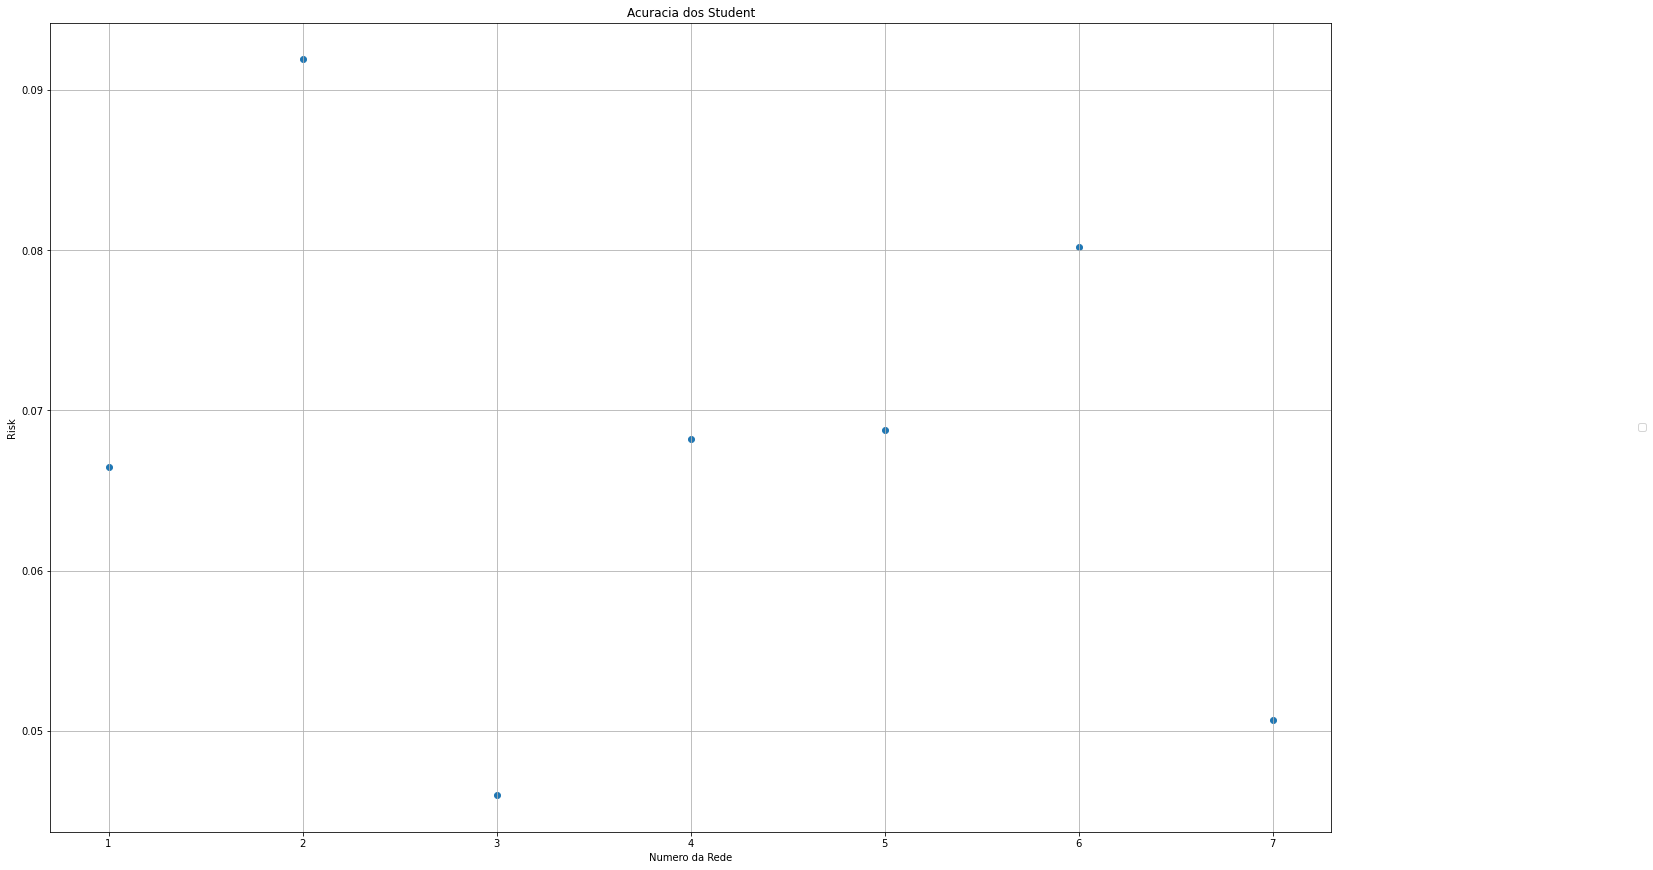

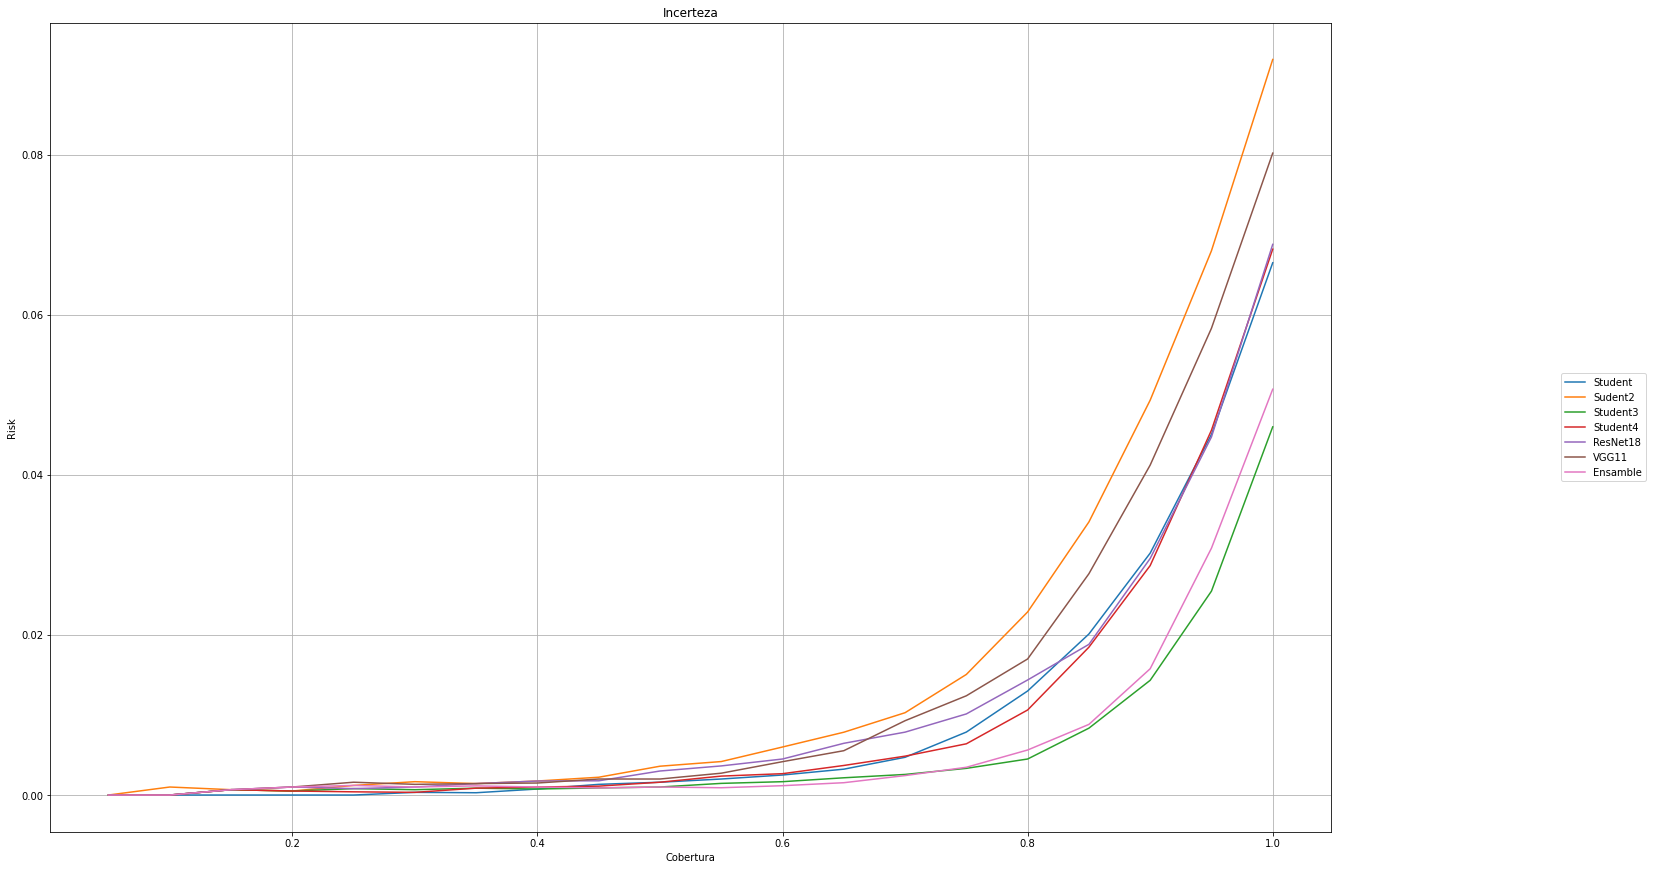

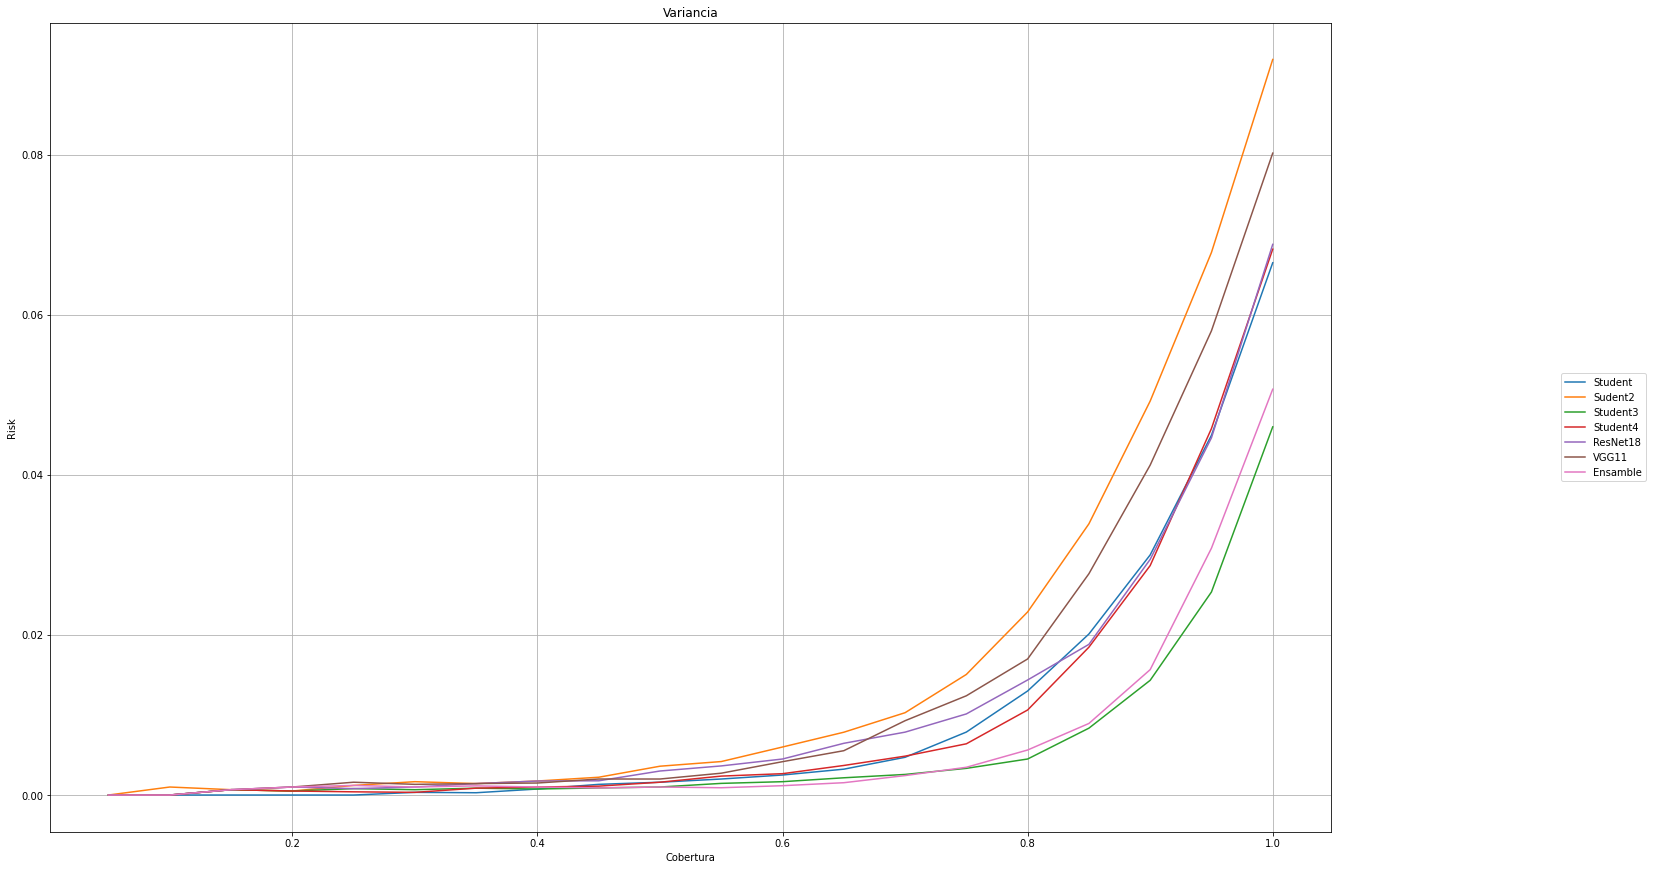

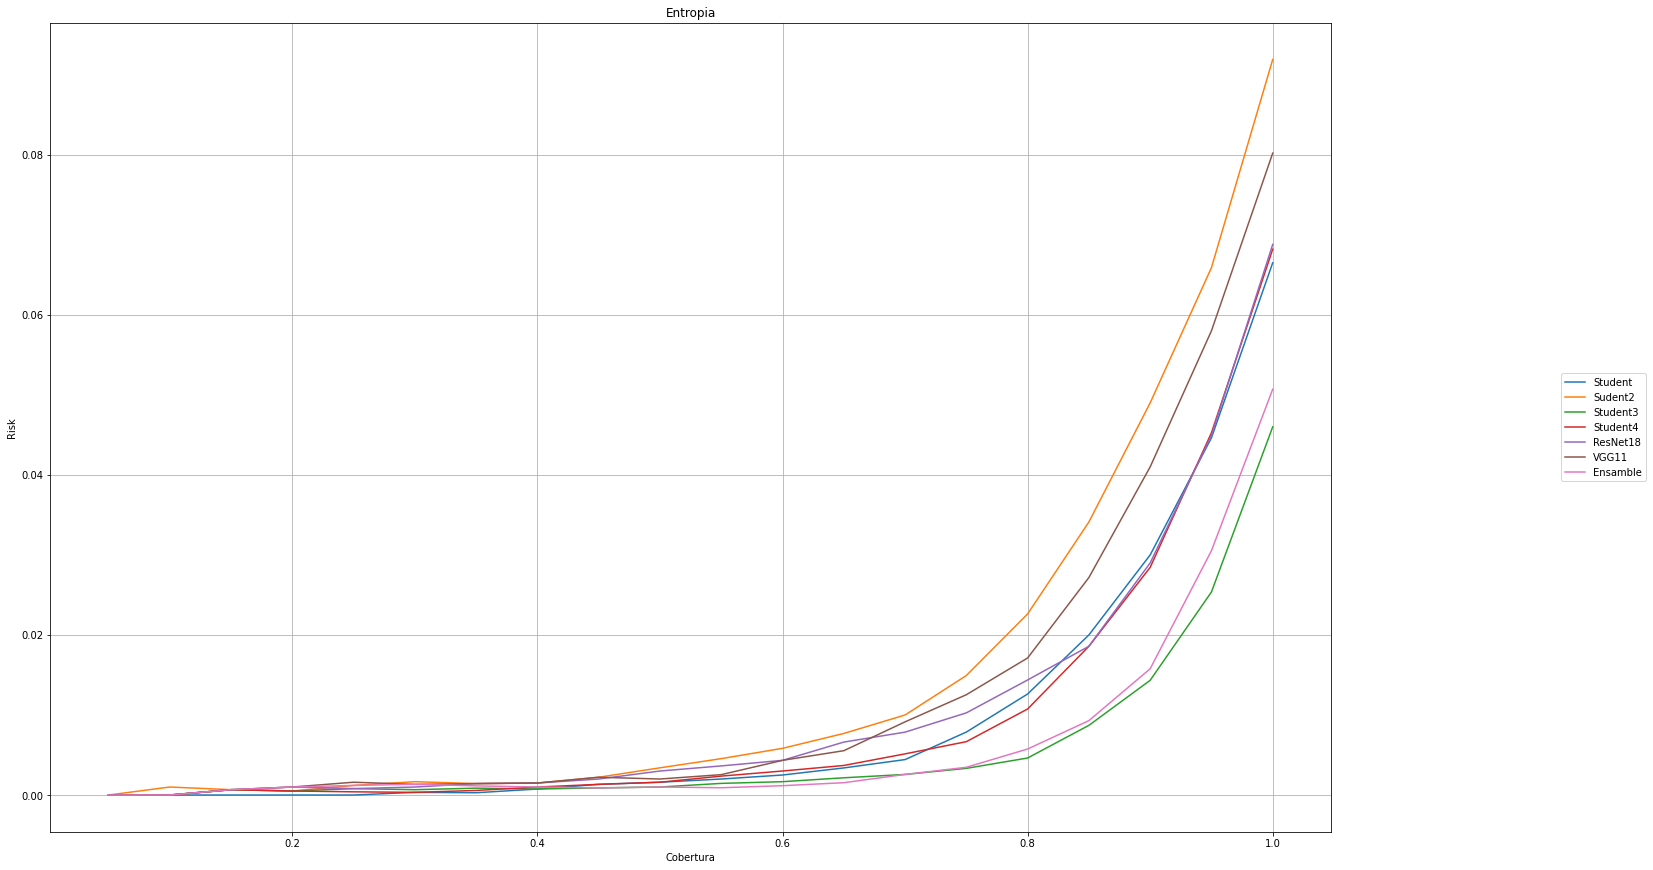

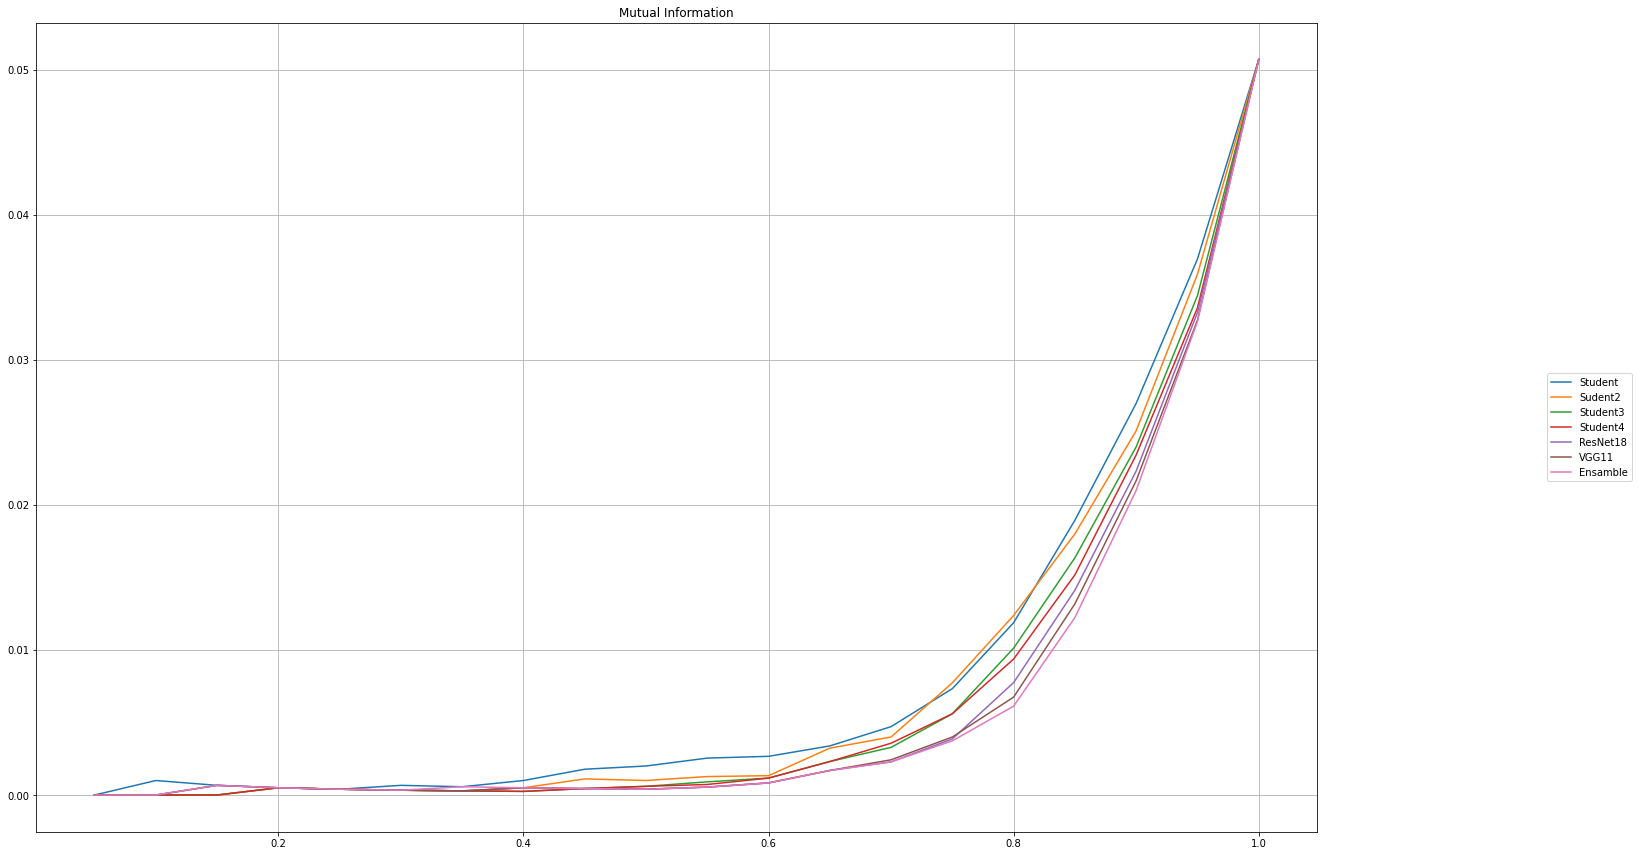

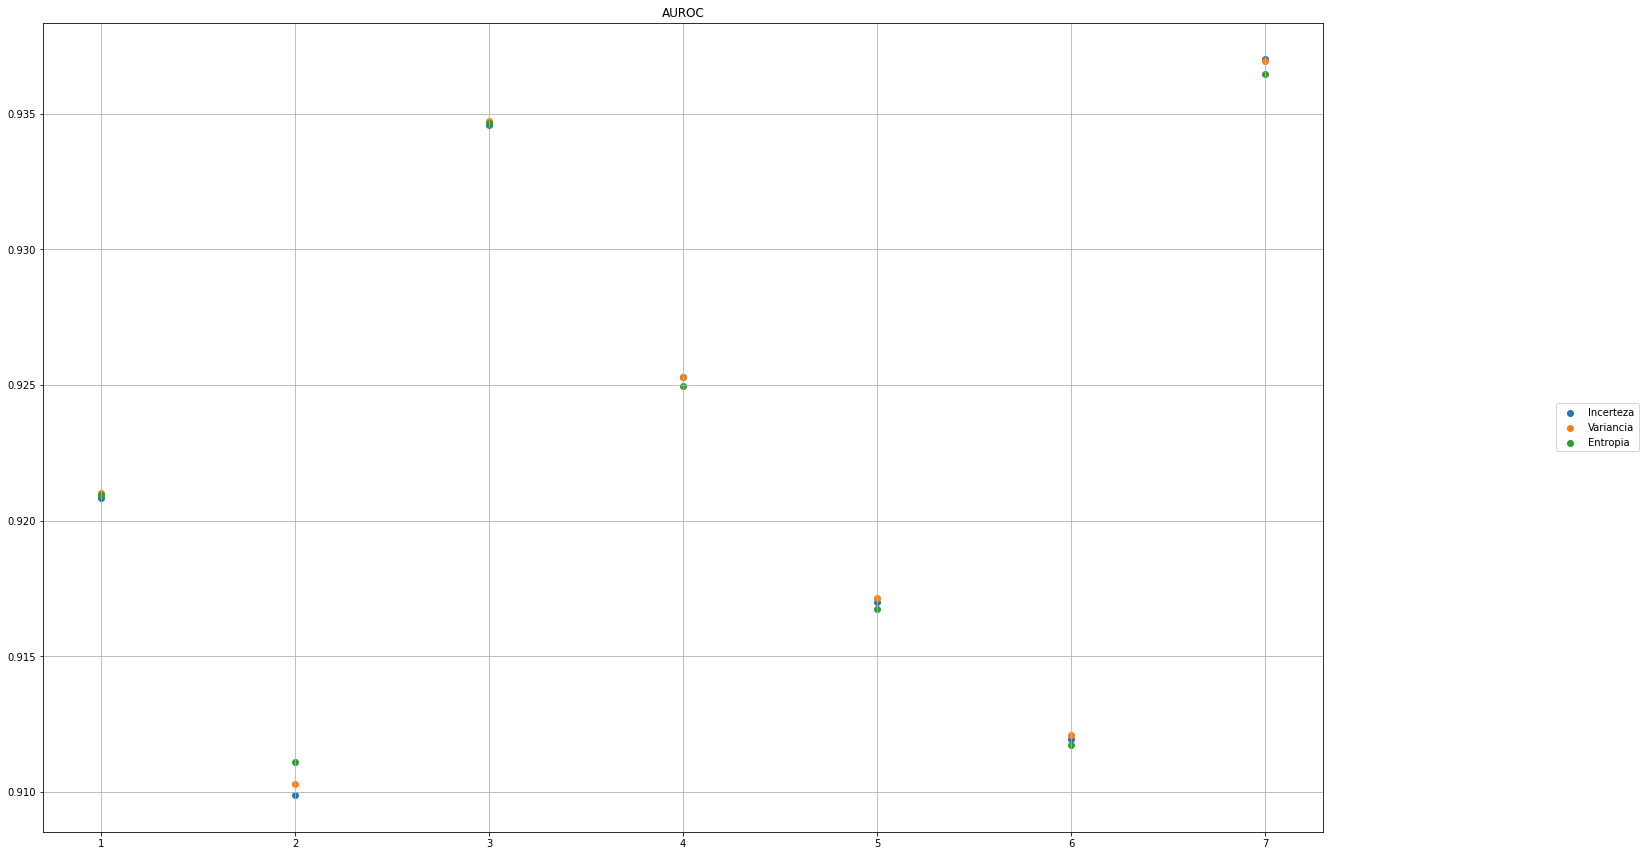

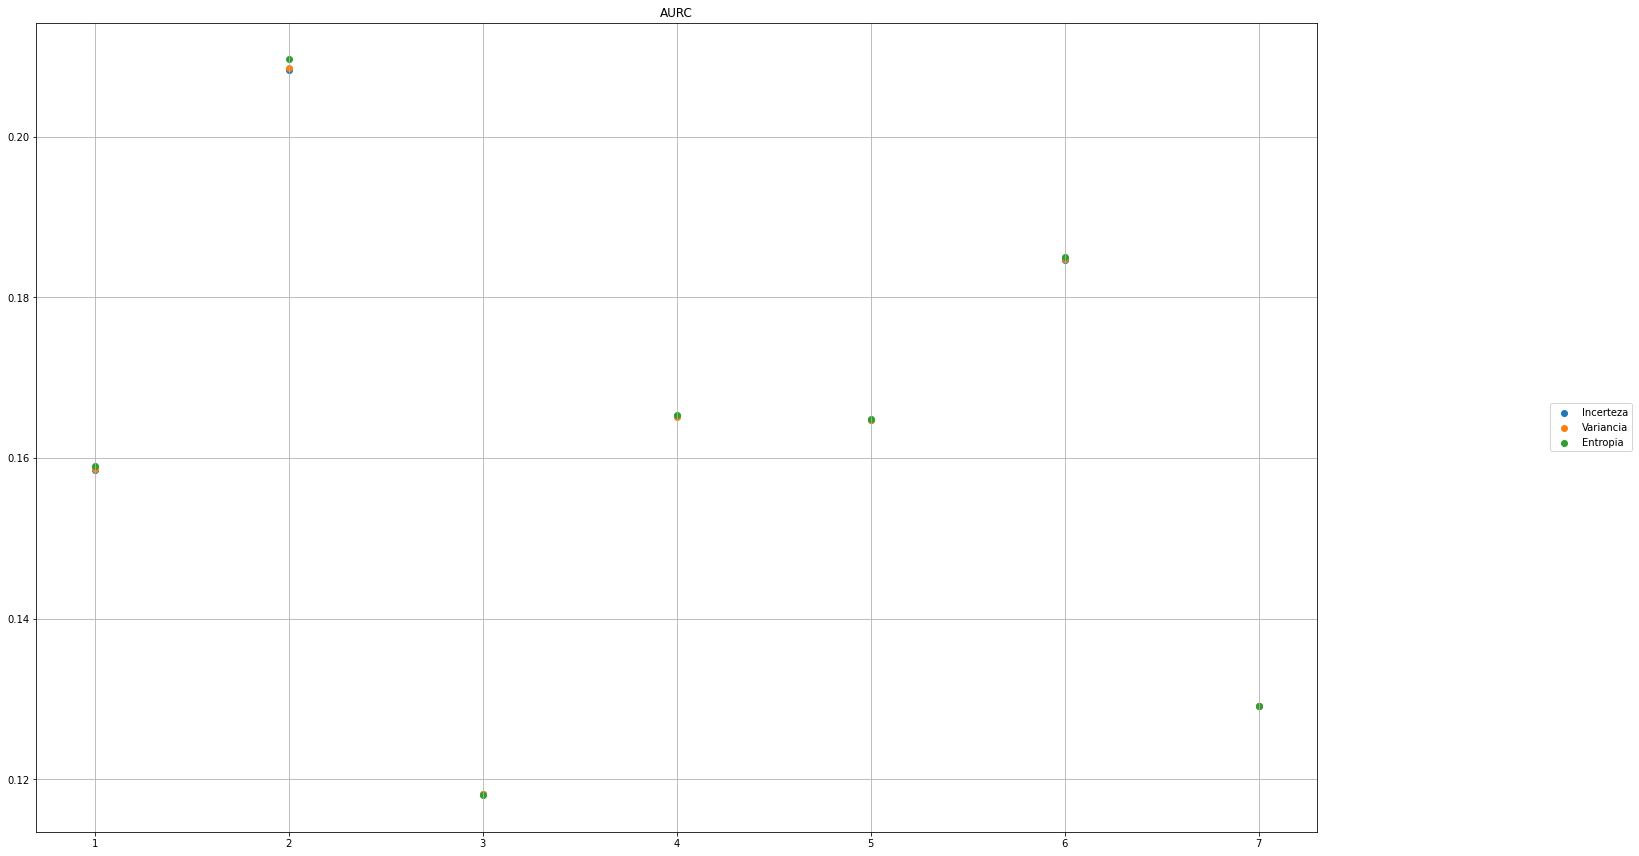

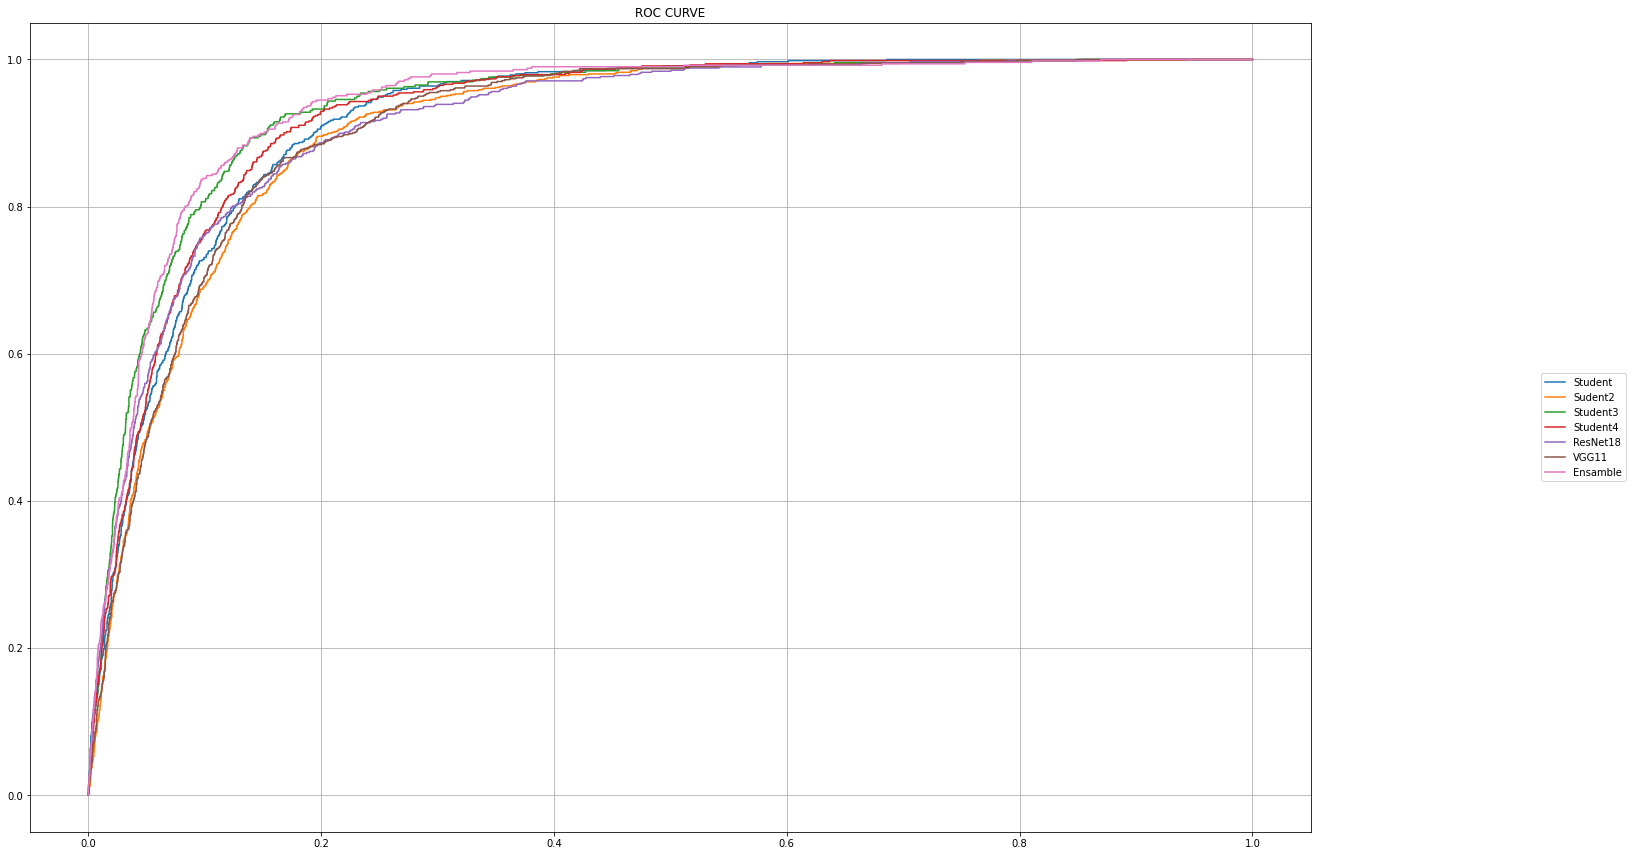

In [66]:
import matplotlib
import matplotlib.pyplot as plt

# Todosos graficos juntos
g1 = plot_graph(X = [1,2,3,4,5,6,7], Y = correct_list, title="Acuracia dos Student", xlabel="Numero da Rede",ylabel="Risk", line=False)

g2 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list1,title="Incerteza",xlabel="Cobertura",ylabel="Risk",label="Student,Sudent2,Student3,Student4,ResNet18,VGG11,Ensamble",multi_label=True)

g3 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list2,title="Variancia",xlabel="Cobertura",ylabel="Risk",label="Student,Sudent2,Student3,Student4,ResNet18,VGG11,Ensamble",multi_label=True)

g4 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list3,title="Entropia",xlabel="Cobertura",ylabel="Risk",label="Student,Sudent2,Student3,Student4,ResNet18,VGG11,Ensamble",multi_label=True)

g5 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=mi_curves,title="Mutual Information",label="Student,Sudent2,Student3,Student4,ResNet18,VGG11,Ensamble",multi_label=True)

g6 = plot_mutiple_graph(X=[1,2,3,4,5,6,7],Y=auroc,title="AUROC",line=False,label="Incerteza,Variancia,Entropia",multi_label=True,n_graphs=3)

g7 = plot_mutiple_graph(X=[1,2,3,4,5,6,7],Y=aurc,title="AURC",line=False,label="Incerteza,Variancia,Entropia",multi_label=True,n_graphs=3)

g8 = plot_mutiple_graph2(X=roc_curve1,Y=roc_curve2,title="ROC CURVE",label="Student,Sudent2,Student3,Student4,ResNet18,VGG11,Ensamble",multi_label=True)

plt.show()

In [67]:
g1.savefig('Acuracia_ensemble.png')
g2.savefig('Incerteza.png')
g3.savefig('Variancia.png')
g4.savefig('Entropia.png')
g5.savefig('MI.png')
g6.savefig('AUROC.png')
g7.savefig('AURC.png')
g8.savefig('ROC_CURVE.png')